In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Weed_Features.csv to Weed_Features.csv


In [4]:
data = pd.read_csv('Weed_Features.csv')

In [5]:
#features = data[['rgb_mean', 'histogram', 'average_intensity', 'laplace_mean', 'edge_mean', 'gabor_response_array', 'std']]
features = data[['rgb_mean', 'average_intensity', 'laplace_mean', 'edge_mean', 'std']]
#features['histogram'] = features['histogram'].apply(lambda x: pd.DataFrame([float(j) for j in [i.strip() for i in x[1:-1].split(' ')] if j]))
gabor = pd.DataFrame(data['gabor_response_array'].apply(lambda x: [float(j) for j in [i.strip() for i in x[1:-1].split(' ')] if j]))
gabor_flattened = pd.DataFrame(gabor['gabor_response_array'].to_list())
features_with_garbor = pd.concat([features, gabor_flattened], axis=1)
labels = data['label']

#Validation function

In [6]:
def validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, param_dict):
  X_tval, X_val, y_tval, y_val = train_test_split(X_train, y_train, test_size=0.2/0.9)
  score_array = []
  for n in list(param_dict.values())[0]:
    im_pipeline.set_params(**{list(param_dict.keys())[0]:n})
    im_pipeline.fit(X_tval, y_tval)
    y_val_pred = im_pipeline.predict(X_val)
    score_array.append(f1_score(y_val, y_val_pred, average='micro'))
  return score_array

#KNN on engineered features with LDA with V and undersampling

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [104]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import neighbors
from sklearn.metrics import f1_score

In [105]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric='euclidean')
im_pipeline = make_pipeline(undersampler, lda, knn)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'kneighborsclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'mean test scores')

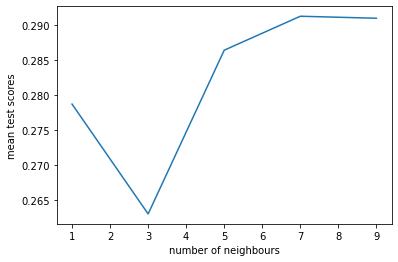

In [106]:
param_name = 'kneighborsclassifier__n_neighbors'
param_values = [x for x in range(1, 10) if x%2 != 0]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xlabel('number of neighbours')
plt.ylabel('mean test scores')

Actual Model:

In [138]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [139]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [140]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, metric='euclidean')
knn_model = knn.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_knn = knn.predict(X_test_LDA)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.25      0.43      0.31       105
           1       0.23      0.41      0.29        94
           2       0.29      0.65      0.40       110
           3       0.19      0.39      0.25        98
           4       0.26      0.53      0.35        90
           5       0.23      0.50      0.32       100
           6       0.22      0.41      0.28       125
           7       0.26      0.31      0.28       104
           8       0.82      0.16      0.27       925

    accuracy                           0.30      1751
   macro avg       0.30      0.42      0.31      1751
weighted avg       0.55      0.30      0.29      1751



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 33.0, 'Predicted')

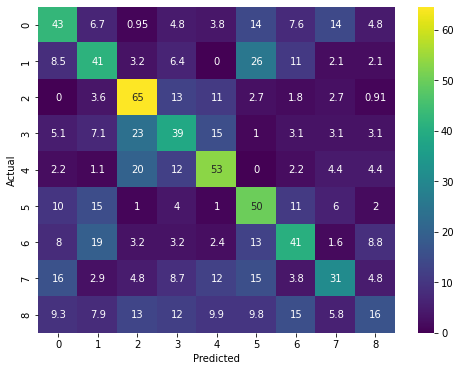

In [141]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_knn[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#SVM on engineered features with LDA with V and undersampling

In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [112]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.metrics import f1_score

In [113]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
svmclf = svm.SVC(kernel='rbf')
im_pipeline = make_pipeline(undersampler, lda, svmclf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'svc', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'mean test scores')

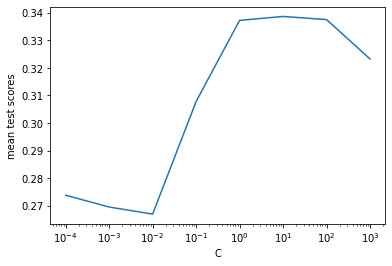

In [114]:
param_name = 'svc__C'
param_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('mean test scores')

Actual Model:

In [142]:
from sklearn import svm
from sklearn.metrics import classification_report

In [143]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [144]:
svmclf = svm.SVC(kernel='rbf', C=1)
svm_model = svmclf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_svm = svmclf.predict(X_test_LDA)
print(classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

           0       0.29      0.39      0.33       105
           1       0.33      0.43      0.37        94
           2       0.29      0.65      0.40       110
           3       0.25      0.56      0.34        98
           4       0.23      0.53      0.32        90
           5       0.25      0.62      0.35       100
           6       0.27      0.48      0.34       125
           7       0.23      0.30      0.26       104
           8       0.83      0.19      0.30       925

    accuracy                           0.33      1751
   macro avg       0.33      0.46      0.34      1751
weighted avg       0.57      0.33      0.32      1751



Text(0.5, 33.0, 'Predicted')

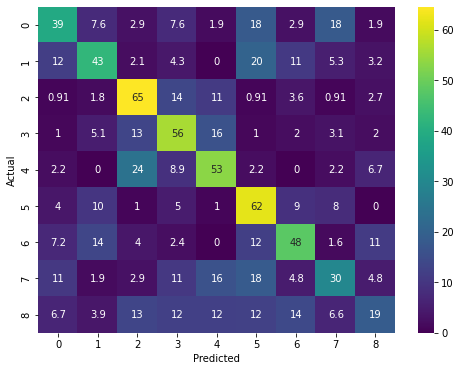

In [145]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_svm[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Random Forest on engineered features with LDA with V and undersampling

In [119]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [120]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [121]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
rf=RandomForestClassifier()
im_pipeline = make_pipeline(undersampler, lda, rf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'randomforestclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__m

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'mean test scores')

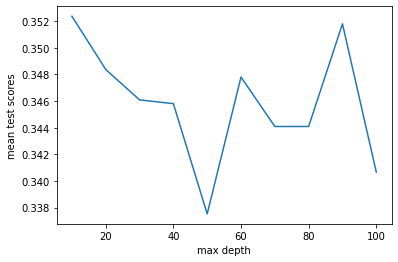

In [122]:
param_name = 'randomforestclassifier__max_depth'
param_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xlabel('max depth')
plt.ylabel('mean test scores')

Actual Model:

In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [147]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [148]:
rf = RandomForestClassifier(max_depth=90)
rf_model = rf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_rf = rf.predict(X_test_LDA)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.27      0.40      0.32       105
           1       0.23      0.38      0.28        94
           2       0.33      0.59      0.42       110
           3       0.27      0.52      0.36        98
           4       0.27      0.59      0.37        90
           5       0.26      0.54      0.35       100
           6       0.28      0.52      0.37       125
           7       0.27      0.39      0.32       104
           8       0.84      0.24      0.37       925

    accuracy                           0.36      1751
   macro avg       0.34      0.46      0.35      1751
weighted avg       0.57      0.36      0.36      1751



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 33.0, 'Predicted')

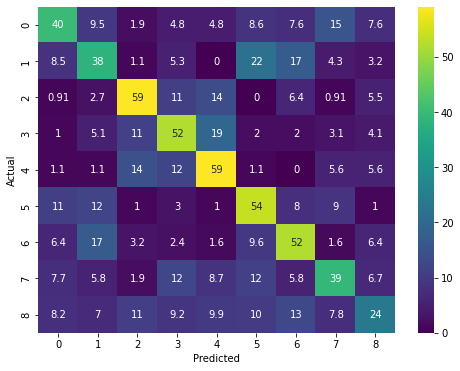

In [149]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_rf[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Logistic Regression on engineered features with LDA with V and undersampling

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [128]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [129]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
lr=LogisticRegression()
im_pipeline = make_pipeline(undersampler, lda, lr)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'logisticregression', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'mean test scores')

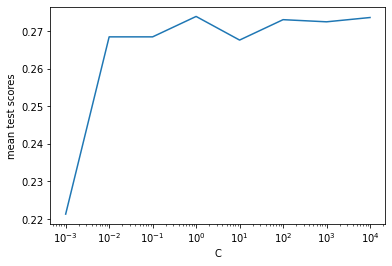

In [130]:
param_name = 'logisticregression__C'
param_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('mean test scores')

Actual Model:

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [151]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [152]:
lr = LogisticRegression(C=0.01)
lr_model = lr.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_lr = lr.predict(X_test_LDA)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.31      0.42      0.35       105
           1       0.23      0.34      0.27        94
           2       0.19      0.64      0.30       110
           3       0.15      0.20      0.17        98
           4       0.15      0.48      0.23        90
           5       0.28      0.48      0.35       100
           6       0.24      0.34      0.28       125
           7       0.12      0.14      0.13       104
           8       0.69      0.15      0.25       925

    accuracy                           0.26      1751
   macro avg       0.26      0.36      0.26      1751
weighted avg       0.46      0.26      0.26      1751



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 33.0, 'Predicted')

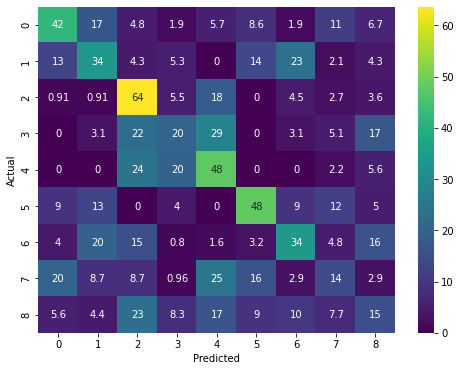

In [153]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_lr[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Dummy classifier for reference

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [155]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

In [156]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [158]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_model = dummy_clf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test)
y_pred_dummy = dummy_clf.predict(X_test_LDA)
print(classification_report(y_test, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.06      0.11      0.08       120
           1       0.04      0.09      0.06        96
           2       0.07      0.14      0.09       101
           3       0.06      0.10      0.08       118
           4       0.10      0.17      0.12       106
           5       0.06      0.09      0.07       111
           6       0.06      0.11      0.08       105
           7       0.04      0.07      0.05       100
           8       0.58      0.11      0.18       894

    accuracy                           0.11      1751
   macro avg       0.12      0.11      0.09      1751
weighted avg       0.32      0.11      0.13      1751



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
